**Importing Libraries and Setting Environment**

In [2]:
# The torch modules are used for the Nueral Network
import torch
import torch.nn as nn
#From this libraries, models will give us Resnet34 which will be used for Feature Extraction
# and in DL tasks, transforms library is used to make the images usable for the models
from torchvision import models, transforms
#DataLoader is used to create the DataLoader object used for DL tasks
#ConcatDataset to create a concatenated dataset of all the three folds in the Dataset
from torch.utils.data import DataLoader, ConcatDataset, Dataset
#ImageFolder module is used to create labelled data from the testing_data
from torchvision.datasets import ImageFolder
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd

import matplotlib.pyplot as plt

**Loading And Preprocessing Data**

In [3]:
#Here, transforms.Compose is used to create the images in a uniform manner
transform = transforms.Compose([
    # Resize to match ResNet's input size
    transforms.Resize((224, 224)), 
    #This creates into Tensor
    transforms.ToTensor(),
    # ImageNet normalization for Z-Score Normalization
    #Images have three channels RGB and so three values of mean and std for individual channel
    #Z-Score=val-mean/std
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Here we are reading the images from each and every fold to create our testing data
#ImageFolder is for labeled data creation, it works like in our case we are having
#images under two folders all and hem, so it creates label in alphabetical order, all-0 & hem-1
#Now, the images under each folder will be assigned that specific label
fold_0_data = ImageFolder("/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0", transform=transform)
fold_1_data = ImageFolder("/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1", transform=transform)
fold_2_data = ImageFolder("/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2", transform=transform)

train_dataset = ConcatDataset([fold_0_data, fold_1_data, fold_2_data])

In [4]:
import os
from PIL import Image

# Custom Dataset class for validation data
#While working with custom dataset, it is compulsary to have __init__,__len__,__getitem__ methods
#Here this class inherits Dataset class
class ValidationDataset(Dataset):
    #Init method will have inclusive call, self is self's insatance
    #img_dir is the path to testing data, #labels_csv path to labels data for testing data
    #transform is if we pass any transform function(made above), else none as default
    def __init__(self, img_dir, labels_csv, transform=None):
        self.img_dir = img_dir
        self.labels = pd.read_csv(labels_csv)

        # Now here, labels is having name and label of that specific image
        #In our case, all is 0 and hem is 1 but in test_labels we have 1 as all and 0 as hem
        #So we are inverting them
        self.labels['labels'] = self.labels['labels'].apply(lambda x: 1 if x == 0 else 0)

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the image path and label
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 1])  # Assuming column 1 contains image names
        image = Image.open(img_name).convert("RGB")  # Load the image in RGB mode
        label = int(self.labels.iloc[idx, 2])  # Assuming column 2 contains the modified label

        if self.transform:
            image = self.transform(image)

        return image, label

# Load the validation dataset
validation_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
validation_dataset = ValidationDataset(validation_dir, 
                                       "/kaggle/input/leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv", 
                                       transform=transform)

# Load the validation data using DataLoader
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

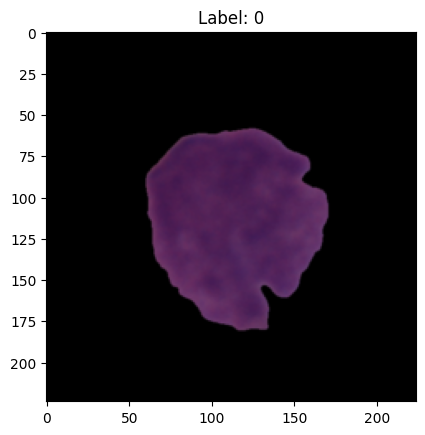

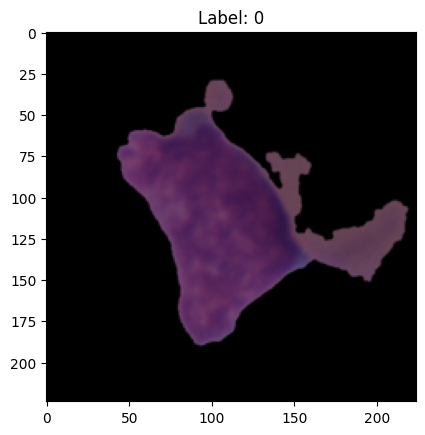

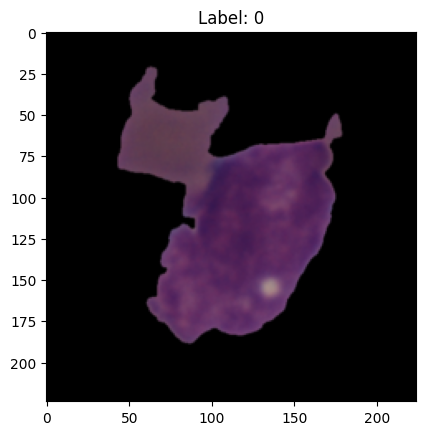

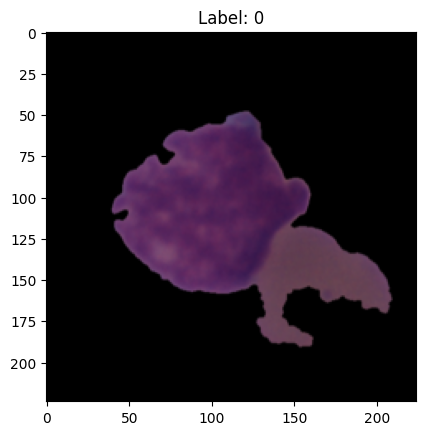

In [5]:
# Function to unnormalize and display an image
def imshow(image, label):
    # Convert image to numpy for displaying
    image = image.numpy().transpose((1, 2, 0))  # Change dimensions to Height x Width x Channels
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean  # Unnormalize the image
    image = np.clip(image, 0, 1)
    
    # Display the image
    plt.imshow(image)
    plt.title(f'Label: {label}')
    plt.show()

# Iterate over the first few samples in the ConcatDataset and display them
for i in range(4):  # Display first 4 samples
    image, label = train_dataset[i]
    imshow(image, label)

**Using Resnet34 Model for Features Extraction**

In [19]:
# Load a pretrained ResNet-50 model
resnet50 = models.resnet34(pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)  # Replace final layer with appropriate number of classes

# Freeze all layers except the final layer
# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50.to(device)

In [14]:
import torch.optim as optim

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss for classification
#Optimizers are used to get the best Weights and Bias pair, over time.
#Adam is a well known one, the first argument tells which all parameters are to be updated, in our case all
#learning rate=0.001, weight_decay is for regularization purpose
optimizer = optim.Adam(resnet50.fc.parameters(), lr=0.001, weight_decay=1e-4)

# Training function for one epoch
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader: #The data will be processed batch wise, in our case 32
        #Putting both of them to the available device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Compute training statistics
        #This will provide us with the 0 or 1 class value based on the maximum values
        _, preds = torch.max(outputs, 1)
        #This computed the total running loss over all the batches
        running_loss += loss.item() * inputs.size(0)
        #Number of correct predictions over all
        correct += (preds == labels).sum().item()
        #It is possible that the last batch can be partially empty so getting the actual length
        total += labels.size(0)
    
    # Calculate training loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    epoch_error = 1 - epoch_acc  # Error = 1 - Accuracy
    
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc * 100:.2f}% | Train Error: {epoch_error * 100:.2f}% | Correct: {correct}")

    return epoch_loss, epoch_acc, epoch_error

In [15]:
# Testing function for one epoch
def test_epoch(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Compute test statistics
            _, preds = torch.max(outputs, 1)  # Get predictions
            running_loss += loss.item() * inputs.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            # Store all predictions and labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate test loss and accuracy
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    epoch_error = 1 - epoch_acc  # Error rate
    
    print(f"Test Loss: {epoch_loss:.4f} | Test Accuracy: {epoch_acc * 100:.2f}% | Test Error: {epoch_error * 100:.2f}% | Correct: {correct} / {total}")
    
    # Return predictions and labels for confusion matrix
    return epoch_loss, epoch_acc, epoch_error, all_preds, all_labels

Epoch 1/8
Train Loss: 0.8386 | Train Accuracy: 35.52% | Train Error: 64.48% | Correct: 3787
Test Loss: 0.8099 | Test Accuracy: 42.47% | Test Error: 57.53% | Correct: 793 / 1867
Epoch 2/8
Train Loss: 0.8395 | Train Accuracy: 35.60% | Train Error: 64.40% | Correct: 3795
Test Loss: 0.8152 | Test Accuracy: 41.62% | Test Error: 58.38% | Correct: 777 / 1867
Epoch 3/8
Train Loss: 0.8396 | Train Accuracy: 35.42% | Train Error: 64.58% | Correct: 3776
Test Loss: 0.8056 | Test Accuracy: 42.26% | Test Error: 57.74% | Correct: 789 / 1867
Epoch 4/8
Train Loss: 0.8388 | Train Accuracy: 35.46% | Train Error: 64.54% | Correct: 3780
Test Loss: 0.7908 | Test Accuracy: 43.28% | Test Error: 56.72% | Correct: 808 / 1867
Epoch 5/8
Train Loss: 0.8386 | Train Accuracy: 35.58% | Train Error: 64.42% | Correct: 3793
Test Loss: 0.8096 | Test Accuracy: 42.74% | Test Error: 57.26% | Correct: 798 / 1867
Epoch 6/8
Train Loss: 0.8394 | Train Accuracy: 35.17% | Train Error: 64.83% | Correct: 3749
Test Loss: 0.7974 | Tes

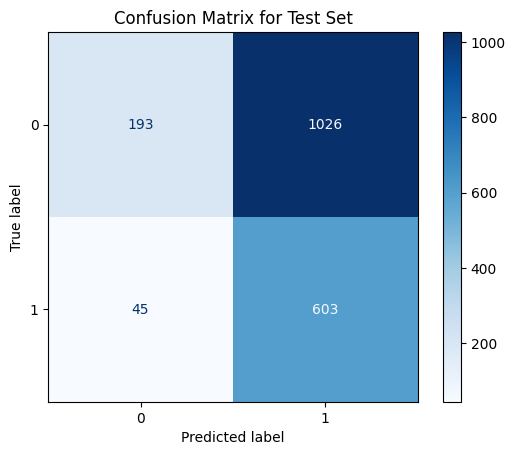

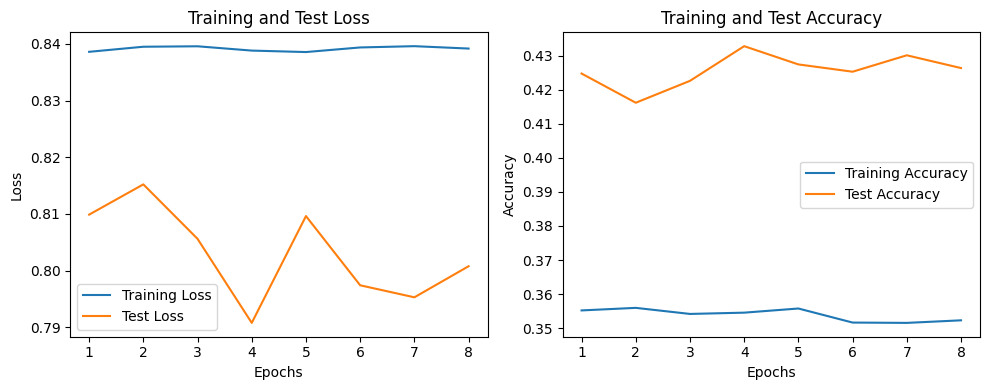

In [20]:
num_epochs = 8

# Lists to track losses, accuracies, and errors over epochs
train_losses = []
train_accuracies = []
train_errors = []
test_losses = []
test_accuracies = []
test_errors = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train for one epoch
    train_loss, train_acc, train_error = train_epoch(resnet50, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_errors.append(train_error)
    
    # Test on the test set after each epoch
    test_loss, test_acc, test_error, all_preds, all_labels = test_epoch(resnet50, validation_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    test_errors.append(test_error)

# Generate and display the confusion matrix for the final test set predictions
conf_matrix = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()

# Plot training and test losses and accuracies over epochs
epochs = range(1, num_epochs + 1)

# Plot losses
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
model_save_path = '/kaggle/working/leukemia_model.pth'  # or '/kaggle/working/lung_colon_model.pth' in the other notebook

# Assuming your model is called `model`
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/leukemia_model.pth
